In [1]:
from glob import glob
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '2' # relevant only for my environment

In [4]:
# Constants

DRUM_CLASSES = [
   'Kick',
   'Snare',
   'Hi-hat closed',
   'Hi-hat open',
   'Tom low',
   'Tom mid', 
   'Tom high',
   'Clap',
   'Rim' 
]

resolution  = 4 # separate quater into 4  = 16 notes per bar

nb_bars = 2 

len_seq = resolution * 4 * nb_bars # length of drumloops in training data - 2 bars
    
nb_notes = len(DRUM_CLASSES) # number of possible MIDI notes  - max_drum_note - min_drum_note


In [5]:
import random
import numpy as np
import os
import pretty_midi
import random
from IPython.display import Audio

import matplotlib.pyplot as plt
%matplotlib inline

MIN_NB_ONSETS = 8

drum_dists = {}

def plot_drum_matrix(a):
    if a is not None:
        a = np.transpose(np.squeeze(a))
        plt.matshow(a)
        plt.show()  

def play_drum_matrix(mat, tempo=120.0):
    # generate audio
    audio_data = get_audio_from_drum_matrix(mat, tempo=tempo)
    display(Audio(audio_data, rate=44100))
    return audio_data

DRUM_MIDI_MAP = [ # pianoroll to MIDI - reverse
    36, # 0 Kick
    38, # 1 Snare
    42, # 2 Hihat Closed
    46, # 3 Hihat Open
    45, # 4 Tom Low
    47, # 5 Tom Mid
    50, # 6 Tom High
    49, # 7 Clap
    51  # 8 Rim
]

def get_audio_from_drum_matrix(mat, tempo=120.):
    pm = pretty_midi.PrettyMIDI(initial_tempo=tempo) # midi object
    pm_inst = pretty_midi.Instrument(0, is_drum=True) # midi instrument
    
    timestep = (60./tempo) / 4. # duration of a 16th note
    for position, timeslot in enumerate(mat):
        for inst, onset in enumerate(timeslot):
            if onset > 0.:
                note_number = DRUM_MIDI_MAP[inst]
                velocity = int(onset * 127.)
                start = timestep * position
                end = timestep * (position + 0.5)
                
                # create a midi note
                note = pretty_midi.Note(velocity=velocity, pitch=note_number, start=start, end=end)
                pm_inst.notes.append(note)
    pm.instruments.append(pm_inst)

    # midi -> audio
    audio_data = pm.fluidsynth()
    return audio_data


In [6]:
import numpy as np

# make sure you have run "0_preprocess_midi.ipynb" in advance
matrices_drums = np.load("./tmp/matrices_drum_gm_electronic.npz")['drum_data']
matrices_genres = np.load("./tmp/matrices_drum_gm_electronic.npz")['genre_ids']
GENRES_ALL = np.load("./tmp/matrices_drum_gm_electronic.npz")['genres']

print(GENRES_ALL)
print(matrices_genres.shape)

# Filter genres 
GENRES_USED = [u'Old Skool', u'DnB', u'Jungle', u'House', u'Breakbeat', u'Garage', u'Techno']
GENRES_ID_USED = [i for i, genre in enumerate(GENRES_ALL) if genre in GENRES_USED]
GENRES = [genre for i, genre in enumerate(GENRES_ALL) if genre in GENRES_USED]

print(GENRES_ID_USED)
print(GENRES)

NB_GENRES = len(GENRES)
print("%d genres we have" % NB_GENRES)

_drums = []
_genres = []

for genre_id, drum in zip(matrices_genres, matrices_drums):
    if genre_id in GENRES_ID_USED:
        _drums.append(drum)
        genre_id = GENRES_ID_USED.index(genre_id)
        _genres.append(genre_id)

matrices_drums = np.array(_drums)
print(matrices_drums.shape)
matrices_genres = np.array(_genres)
print(matrices_genres.shape)

[u'Old Skool' u'Trance' u'DnB' u'Basic' u'Downtempo' u'Jungle' u'House'
 u'Breakbeat' u'Garage' u'Techno']
(49003,)
[0, 2, 5, 6, 7, 8, 9]
[u'Old Skool', u'DnB', u'Jungle', u'House', u'Breakbeat', u'Garage', u'Techno']
7 genres we have
(37950, 32, 9)
(37950,)


(u'Old Skool', 3595)


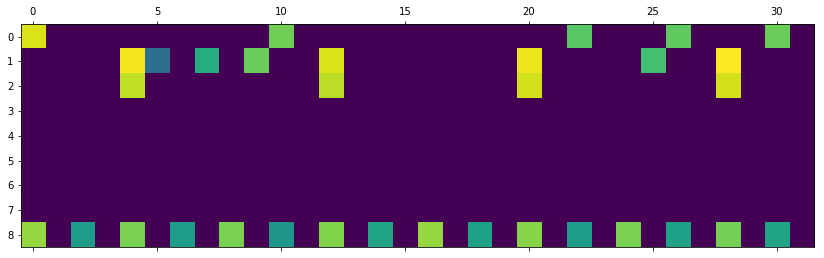

(u'DnB', 6931)


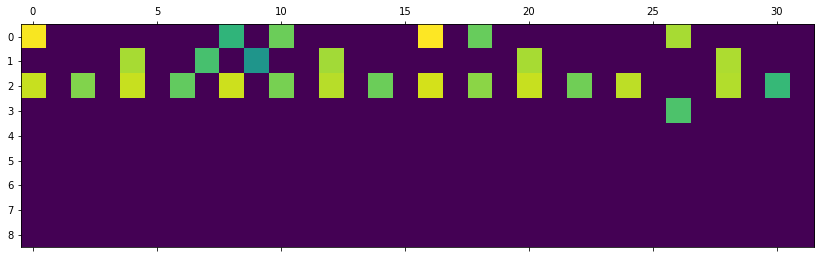

(u'Jungle', 4795)


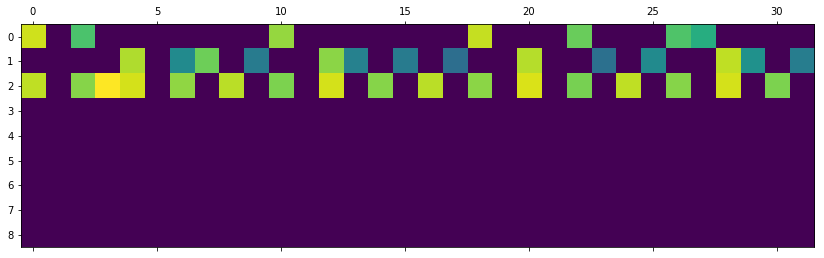

(u'House', 3595)


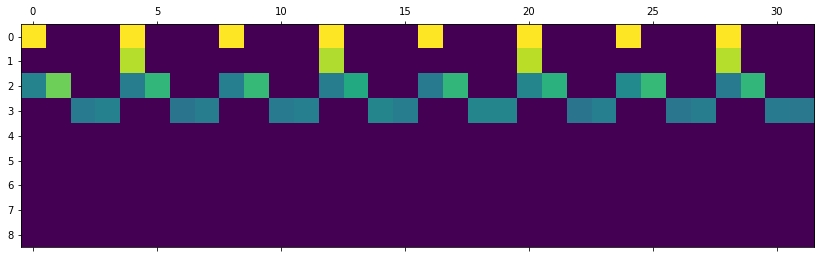

(u'Breakbeat', 8403)


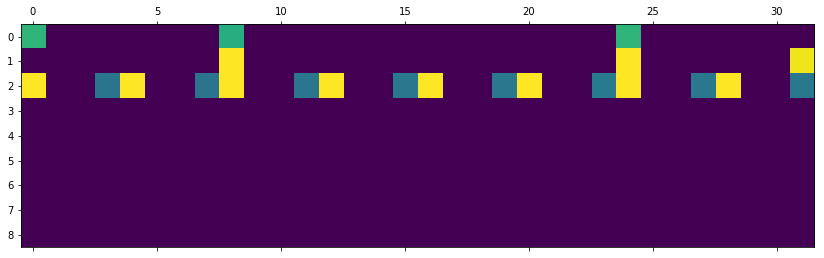

(u'Garage', 6618)


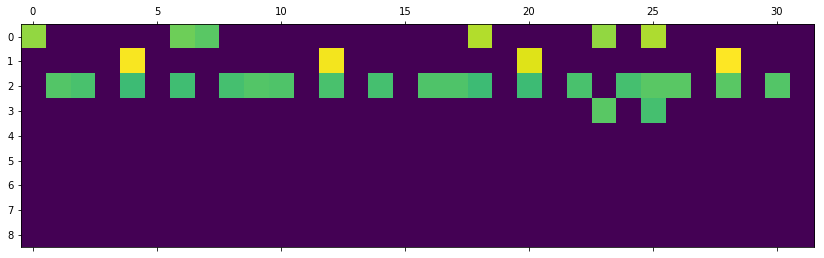

(u'Techno', 4013)


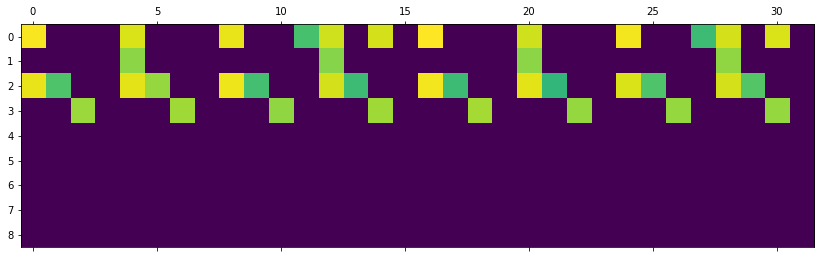

In [7]:
for i, genre in enumerate(GENRES):
    a = matrices_drums[matrices_genres == i]
    print(genre, int(a.shape[0]))
    plot_drum_matrix(a[0])
    play_drum_matrix(a[0])
    

In [8]:
import numpy as np
from keras.layers import Input, Dense, Flatten, Dropout, Reshape, LSTM, Bidirectional, Lambda, Concatenate, Softmax
from keras.layers.convolutional import Conv2D

from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop, Adam
import keras.backend as K
from keras.models import Model, Sequential

batch_size = 16
n_z = 4
dropout_rate = 0.30

# encoder
drum_input = Input(shape=(len_seq, nb_notes), name='drum_input')  # tensorflow order
x = Bidirectional(LSTM(64, return_sequences=True, activation='tanh'))(drum_input) 
x = Bidirectional(LSTM(128, return_sequences=True, activation='tanh'))(x)
x = Bidirectional(LSTM(16, return_sequences=True, activation='tanh'))(x)
x1 = Reshape((1024,))(x)
x = Dense(512, activation='relu')(x1)
x = Dense(256, activation='relu')(x)
x = Dense(NB_GENRES)(x)
output = Softmax()(x)

model = Model(drum_input, output)
model.summary()


Using TensorFlow backend.
W0823 16:27:48.654666 140653318456704 deprecation_wrapper.py:119] From /home/nao/anaconda3/envs/p2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 16:27:48.705744 140653318456704 deprecation_wrapper.py:119] From /home/nao/anaconda3/envs/p2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0823 16:27:48.707890 140653318456704 deprecation_wrapper.py:119] From /home/nao/anaconda3/envs/p2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
drum_input (InputLayer)      (None, 32, 9)             0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32, 128)           37888     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 32, 256)           263168    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 32, 32)            34944     
_________________________________________________________________
reshape_1 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
__________

In [9]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical 

genre_ids = to_categorical(matrices_genres, num_classes=NB_GENRES)

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
cp = ModelCheckpoint("./tmp/rythm_classification_gm_{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', verbose=1, save_best_only=True, period=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

BATCH_SIZE = 64

model.fit(matrices_drums, genre_ids, 
        shuffle=True, batch_size=BATCH_SIZE, epochs=100, verbose=1, validation_split=0.1, callbacks=[es, cp])

W0823 16:27:50.246140 140653318456704 deprecation_wrapper.py:119] From /home/nao/anaconda3/envs/p2/lib/python2.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0823 16:27:50.269471 140653318456704 deprecation_wrapper.py:119] From /home/nao/anaconda3/envs/p2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0823 16:27:50.897447 140653318456704 deprecation.py:323] From /home/nao/anaconda3/envs/p2/lib/python2.7/site-packages/tensorflow/python/ops/math_grad.py:1250: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0823 16:27:53.948474 140653318456704 deprecation_wrapper.py:119] From /home/nao/anaconda3/envs/p2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:986: 

Train on 34155 samples, validate on 3795 samples
Epoch 1/100
34155/34155 [==============================] - 161s 5ms/step - loss: 0.8732 - acc: 0.6607 - val_loss: 0.2581 - val_acc: 0.9278
Epoch 2/100
34155/34155 [==============================] - 143s 4ms/step - loss: 0.1508 - acc: 0.9487 - val_loss: 0.1287 - val_acc: 0.9507
Epoch 3/100
34155/34155 [==============================] - 143s 4ms/step - loss: 0.0588 - acc: 0.9805 - val_loss: 0.0223 - val_acc: 0.9921

Epoch 00003: val_loss improved from inf to 0.02231, saving model to ./tmp/rythm_classification_gm_03-0.02.hdf5
Epoch 4/100
34155/34155 [==============================] - 143s 4ms/step - loss: 0.0334 - acc: 0.9885 - val_loss: 0.0044 - val_acc: 0.9992
Epoch 5/100
34155/34155 [==============================] - 144s 4ms/step - loss: 0.0208 - acc: 0.9928 - val_loss: 0.0056 - val_acc: 0.9976
Epoch 6/100
34155/34155 [==============================] - 145s 4ms/step - loss: 0.0180 - acc: 0.9946 - val_loss: 0.0049 - val_acc: 0.9992

Epoc

In [10]:
model.save("./tmp/rhythm_classification_gm.h5")